In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
digits = load_digits()

class KDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
        kernel=self.kernel).fit(Xi) for Xi in training_sets]
        self.log_priors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self

    def predict_proba(self, X):
        log_probs = np.array([model.score_samples(X) for model in self.models_]).T
        result = np.exp(log_probs + self.log_priors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [2]:
features = digits.data
target = digits.target
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3,random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
kde = KDEClassifier()
kde.fit(X_train,y_train)
y_pred = kde.predict(X_test)
(y_pred == y_test).mean()

<ipython-input-1-5d2112ccdc34>:28: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)


0.9703703703703703

Text(0, 0.5, 'accuracy')

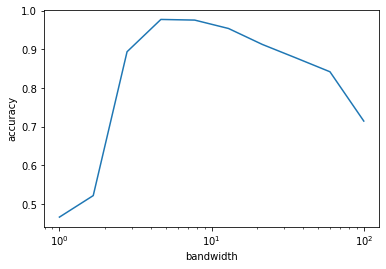

In [3]:
bandwidths = 10 ** np.linspace(0, 2, 10)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths},cv=10)
grid.fit(features,target)
scores = grid.cv_results_['mean_test_score']

plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')

In [4]:
nb_clf = GaussianNB()
nb_clf.fit(X_train,y_train)
cross_val_score(GaussianNB(), features, target).mean()

0.8069281956050759

In [5]:
confusion_matrix(y_test,y_pred) # KDE

array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 51,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 52,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 53,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0, 55,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 60,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 52,  0,  0],
       [ 0,  1,  1,  2,  0,  0,  0,  0, 57,  0],
       [ 0,  0,  0,  2,  0,  1,  0,  1,  0, 53]], dtype=int64)

In [6]:
confusion_matrix(y_test,nb_clf.predict(X_test))

array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 47,  0,  0,  0,  0,  0,  0,  5,  0],
       [ 0, 10, 17, 10,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  0, 46,  0,  0,  0,  1,  6,  1],
       [ 0,  4,  0,  0, 26,  0,  3, 15,  0,  0],
       [ 0,  1,  0,  2,  0, 50,  1,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 60,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 52,  0,  0],
       [ 0, 12,  0,  4,  0,  1,  0,  3, 41,  0],
       [ 0,  2,  0, 15,  1,  0,  0,  3,  5, 31]], dtype=int64)